In [2]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
from nettack import GCN
from nettack import nettack as ntk
from nettack import utils

gpu_id = 0  # set this to your desired GPU ID if you want to use GPU computations (only for the GCN/surrogate training)

### Load network, basic setup

In [20]:
_A_obs, _X_obs, _z_obs = utils.load_npz("data/citeseer.npz")
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)

_A_obs = _A_obs[lcc][:, lcc]

assert np.abs(_A_obs - _A_obs.T).sum() == 0, "Input graph is not symmetric"
assert (
    _A_obs.max() == 1 and len(np.unique(_A_obs[_A_obs.nonzero()].A1)) == 1
), "Graph must be unweighted"
assert _A_obs.sum(0).A1.min() > 0, "Graph contains singleton nodes"

_X_obs = _X_obs[lcc].astype("float32")
_z_obs = _z_obs[lcc]
_N = _A_obs.shape[0]
_K = _z_obs.max() + 1
_Z_obs = np.eye(_K)[_z_obs]
_An = utils.preprocess_graph(_A_obs)
sizes = [16, _K]
degrees = _A_obs.sum(0).A1

seed = 15
unlabeled_share = 0.8
val_share = 0.1
train_share = 1 - unlabeled_share - val_share
np.random.seed(seed)

split_train, split_val, split_unlabeled = utils.train_val_test_split_tabular(
    np.arange(_N),
    train_size=train_share,
    val_size=val_share,
    test_size=unlabeled_share,
    stratify=_z_obs,
)

Selecting 1 largest connected components


### Choose the node to attack

In [30]:
u = 10  # node to attack
assert u in split_unlabeled

### Train surrogate model (i.e. GCN without nonlinear activation)

In [22]:
surrogate_model = GCN.GCN(
    sizes, _An, _X_obs, with_relu=False, name="surrogate", gpu_id=gpu_id
)
surrogate_model.train(split_train, split_val, _Z_obs)
W1 = surrogate_model.W1.eval(session=surrogate_model.session)
W2 = surrogate_model.W2.eval(session=surrogate_model.session)

/homes/eutiushe/scratch/conda/envs/tf1/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 37 iterations


### Setup Nettack

In [31]:
nettack = ntk.Nettack(_A_obs, _X_obs, _z_obs, W1, W2, u, verbose=True)

In [45]:
direct_attack = False
n_influencers = 1 if direct_attack else 3
n_perturbations = int(
    degrees[u]
)  # How many perturbations to perform. Default: Degree of the node
perturb_features = True
perturb_structure = True

In [46]:
degrees[u]

3.0

### Poison the data

In [47]:
nettack.reset()
nettack.attack_surrogate(
    n_perturbations,
    perturb_structure=perturb_structure,
    perturb_features=perturb_features,
    direct=direct_attack,
    n_influencers=n_influencers,
)

##### Starting attack #####
##### Attack node with ID 10 using structure and feature perturbations #####
##### Attacking the node indirectly via 3 influencer nodes #####
##### Performing 3 perturbations #####
Influencer nodes: [ 990 1242  412]
##### ...1/3 perturbations ... #####
Edge perturbation: [412 374]
##### ...2/3 perturbations ... #####
Edge perturbation: [ 990 2095]
##### ...3/3 perturbations ... #####
Edge perturbation: [1242 2045]


In [9]:
print(nettack.structure_perturbations)

[(0, 1664), (0, 1084), (0, 1009), (0, 1046), (0, 1301)]


In [10]:
print(nettack.feature_perturbations)

[(), (), (), (), ()]


In [11]:
dir(nettack)

['K',
 'N',
 'W',
 'W1',
 'W2',
 'X_obs',
 'X_obs_orig',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'adj',
 'adj_no_selfloops',
 'adj_orig',
 'adj_preprocessed',
 'attack_surrogate',
 'compute_XW',
 'compute_cooccurrence_constraint',
 'compute_logits',
 'compute_new_a_hat_uv',
 'cooc_constraint',
 'cooc_matrix',
 'feature_perturbations',
 'feature_scores',
 'get_attacker_nodes',
 'gradient_wrt_x',
 'influencer_nodes',
 'label_u',
 'potential_edges',
 'reset',
 'strongest_wrong_class',
 'struct_score',
 'structure_perturbations',
 'u',
 'verbose',
 'z_obs']

### Train GCN without perturbations

In [11]:
retrain_iters = 5

In [12]:
classification_margins_clean = []
class_distrs_clean = []
gcn_before = GCN.GCN(sizes, _An, _X_obs, "gcn_orig", gpu_id=gpu_id)
for _ in range(retrain_iters):
    print("... {}/{} ".format(_ + 1, retrain_iters))
    gcn_before.train(split_train, split_val, _Z_obs)
    probs_before_attack = gcn_before.predictions.eval(
        session=gcn_before.session, feed_dict={gcn_before.node_ids: [nettack.u]}
    )[0]
    class_distrs_clean.append(probs_before_attack)
    best_second_class_before = (probs_before_attack - 1000 * _Z_obs[nettack.u]).argmax()
    margin_before = (
        probs_before_attack[_z_obs[nettack.u]]
        - probs_before_attack[best_second_class_before]
    )
    classification_margins_clean.append(margin_before)
class_distrs_clean = np.array(class_distrs_clean)

/homes/eutiushe/scratch/conda/envs/tf1/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 80 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 44 iterations
... 5/5 
converged after 66 iterations


### Train GCN with perturbations
(insert your favorite node classification algorithm here)

In [13]:
classification_margins_corrupted = []
class_distrs_retrain = []
gcn_retrain = GCN.GCN(
    sizes, nettack.adj_preprocessed, nettack.X_obs.tocsr(), "gcn_retrain", gpu_id=gpu_id
)
for _ in range(retrain_iters):
    print("... {}/{} ".format(_ + 1, retrain_iters))
    gcn_retrain.train(split_train, split_val, _Z_obs)
    probs_after_attack = gcn_retrain.predictions.eval(
        session=gcn_retrain.session, feed_dict={gcn_retrain.node_ids: [nettack.u]}
    )[0]
    best_second_class_after = (probs_after_attack - 1000 * _Z_obs[nettack.u]).argmax()
    margin_after = (
        probs_after_attack[_z_obs[nettack.u]]
        - probs_after_attack[best_second_class_after]
    )
    class_distrs_retrain.append(probs_after_attack)
    classification_margins_corrupted.append(margin_after)
class_distrs_retrain = np.array(class_distrs_retrain)

/homes/eutiushe/scratch/conda/envs/tf1/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 93 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 61 iterations
... 4/5 
converged after 47 iterations
... 5/5 
converged after 49 iterations


### Visualize results

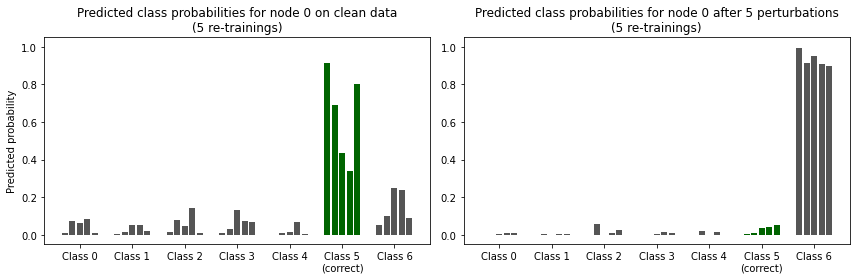

In [14]:
def make_xlabel(ix, correct):
    if ix == correct:
        return "Class {}\n(correct)".format(ix)
    return "Class {}".format(ix)


figure = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
center_ixs_clean = []
for ix, block in enumerate(class_distrs_clean.T):
    x_ixs = np.arange(len(block)) + ix * (len(block) + 2)
    center_ixs_clean.append(np.mean(x_ixs))
    color = "#555555"
    if ix == nettack.label_u:
        color = "darkgreen"
    plt.bar(x_ixs, block, color=color)

ax = plt.gca()
plt.ylim((-0.05, 1.05))
plt.ylabel("Predicted probability")
ax.set_xticks(center_ixs_clean)
ax.set_xticklabels([make_xlabel(k, nettack.label_u) for k in range(_K)])
ax.set_title(
    "Predicted class probabilities for node {} on clean data\n({} re-trainings)".format(
        nettack.u, retrain_iters
    )
)

fig = plt.subplot(1, 2, 2)
center_ixs_retrain = []
for ix, block in enumerate(class_distrs_retrain.T):
    x_ixs = np.arange(len(block)) + ix * (len(block) + 2)
    center_ixs_retrain.append(np.mean(x_ixs))
    color = "#555555"
    if ix == nettack.label_u:
        color = "darkgreen"
    plt.bar(x_ixs, block, color=color)


ax = plt.gca()
plt.ylim((-0.05, 1.05))
ax.set_xticks(center_ixs_retrain)
ax.set_xticklabels([make_xlabel(k, nettack.label_u) for k in range(_K)])
ax.set_title(
    "Predicted class probabilities for node {} after {} perturbations\n({} re-trainings)".format(
        nettack.u, n_perturbations, retrain_iters
    )
)
plt.tight_layout()
plt.show()